In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from numpy import cumsum
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib

In [3]:
df = pd.read_csv('/Users/CourtneyTaylor/Downloads/medical_time_series .csv')

In [4]:
df.columns

Index(['Day', 'Revenue'], dtype='object')

In [5]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [6]:
df.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [7]:
#Day & Date Time Formats
#convert days to dates in time series
df['Date'] = (pd.date_range(start=datetime(2019, 1, 1),
                            periods=df.shape[0], freq='24H'))

#setting day as index
df.set_index('Date', inplace=True)
df

,Day,Revenue
Date,,
2019-01-01,1,0.000000
2019-01-02,2,-0.292356
2019-01-03,3,-0.327772
2019-01-04,4,-0.339987
2019-01-05,5,-0.124888
...,...,...
2020-12-27,727,15.722056
2020-12-28,728,15.865822
2020-12-29,729,15.708988


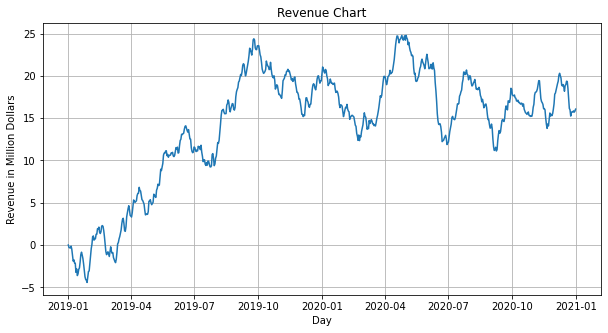

In [8]:
#Visualizing
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in Million Dollars')
plt.grid(True)
plt.show()

In [9]:
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,14.179608
std,211.165812,6.959905
min,1.000000,-4.423299
25%,183.500000,11.121742
50%,366.000000,15.951830
75%,548.500000,19.293506
max,731.000000,24.792249


In [10]:
#drop any nulls
df.dropna()

,Day,Revenue
Date,,
2019-01-01,1,0.000000
2019-01-02,2,-0.292356
2019-01-03,3,-0.327772
2019-01-04,4,-0.339987
2019-01-05,5,-0.124888
...,...,...
2020-12-27,727,15.722056
2020-12-28,728,15.865822
2020-12-29,729,15.708988


In [11]:
#Stationarity
result = adfuller(df['Revenue'])

print("Test Statistics: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ", result[4])

Test Statistics:  -2.218319047608946
p-value:  0.19966400615064328
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [12]:
#H0 - Non-stationary
#H1 - Stationary
if result[1] <= 0.05:
    print("Reject Null Hypothesis; Stationary")
else:
    print("Fail to Reject Null Hypothesis; Non-Stationary")

Fail to Reject Null Hypothesis; Non-Stationary


In [13]:
#Make time series stationary
df_stationary = df.diff().dropna()
df_stationary.head()

,Day,Revenue
Date,,
2019-01-02,1.0,-0.292356
2019-01-03,1.0,-0.035416
2019-01-04,1.0,-0.012215
2019-01-05,1.0,0.215100
2019-01-06,1.0,-0.366702


In [14]:
df = df.drop(columns=['Day'])

In [15]:
#Rechecking Stationarity
result = adfuller(df_stationary['Revenue'])

print("Test Statistics: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ", result[4])

#H0 - Non-stationary
#H1 - Stationary
if result[1] <= 0.05:
    print("Reject Null Hypothesis; Stationary")
else:
    print("Fail to Reject Null Hypothesis; Non-Stationary")

Test Statistics:  -17.374772303557062
p-value:  5.113206978840171e-30
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject Null Hypothesis; Stationary


In [16]:
#Export clean data
pd.DataFrame(df_stationary).to_csv('D213Task1.csv')

In [17]:
#Test/Train
X_train = df.loc[:'2020-09-30']
X_test = df.loc['2020-10-01':]

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train Shape (639, 1)
X_test Shape (92, 1)


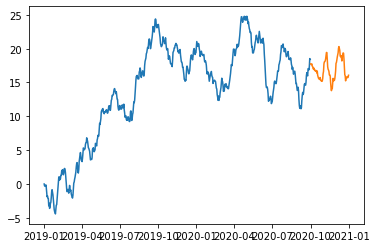

In [18]:
plt.plot(X_train)
plt.plot(X_test)

In [19]:
#Export train and test sets
X_train.to_csv('d213t1_train.csv')
X_test.to_csv('d213t1_test.csv')

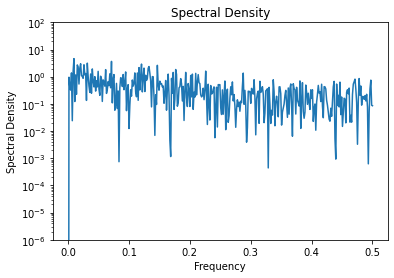

In [20]:
#spectral density
f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f,Pxx_den)
plt.ylim([1e-6,1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

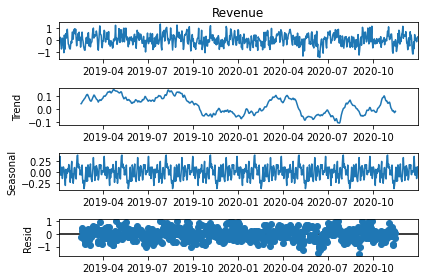

In [21]:
#Decomposition
decomp = seasonal_decompose(df_stationary['Revenue'], period=90)

decomp.plot()
plt.show()

<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

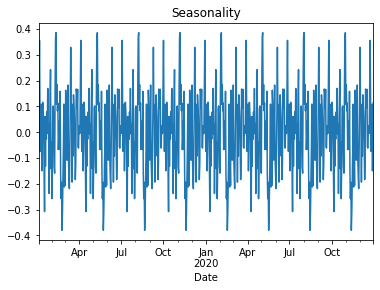

In [22]:
plt.title('Seasonality')
decomp.seasonal.plot()

In [ ]:
#Trends
plt.title('Trend')
decomp.trend.plot()

In [ ]:
#residuals
plt.title('Residuals')
decomp.resid.plot()

In [ ]:
plot_acf(df);

In [ ]:
plot_pacf(df);

In [ ]:
#Best order by AIC
best_aic = np.inf
best_order = None
best_mdl = None
rng = range(3)
for p in rng: #Loop over p values
    for q in rng: #Loop over q values
        try: 
            
            #Create & fit ARIMA(p,q) model
            model = SARIMAX(df, order=(p,1,q), trend='c')
            results = model.fit()
            tmp_aic = results.aic
            print(p,q,results.aic, results.bic)
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p,q)
                best_mdl = tmp_mdl
        except:
                    print(p,q, None, None)

print('\Best AIC: {:6.5f} | order: {}'.format(best_aic, best_order))

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
import pmdarima as pmd
model = pmd.auto_arima(df, start_p=0, start_q=0)
model.summary()

In [ ]:
model=SARIMAX(df, order=(1,1,0),seasonal_order=(1,1,0,90))
results = model.fit()
results.summary

In [ ]:
mae = np.mean(np.abs(results.resid))
print("Mean absolute error", mae)

In [ ]:
results.plot_diagnostics().show()

In [ ]:
#Create the predictions
prediction = results.get_prediction(start=-90)

#Get predictions
mean_prediction = prediction.predicted_mean

#Confidence intervals
confidence_intervals = prediction.conf_int()

#Confidence intervals upper and lower limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:, 'upper Revenue']


In [ ]:
#plotting the data
plt.figure(figsize=(12,4))
plt.plot(X_test.index, X_test.values, label='observed (test set)')

#plotting mean predictions
plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')

#filling in area between confidence levels
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

#labels & legends/plot
plt.title('Forecast comparing with test data')
plt.xlabel('Date')
plt.ylabel('Revenue in millions$')
plt.legend()
plt.show()

In [ ]:
#forecast
diff_forecast = results.get_forecast(steps=180)
mean_forecast = diff_forecast.predicted_mean
print(mean_forecast.head(5))
#confidence level
confidence_intervals = diff_forecast.conf_int()
#select lower and upper CIs
lower_limits = confidence_intervals.loc[:, 'lower Revenue']
upper_limits = confidence_intervals.loc[:, 'upper Revenue']

In [ ]:
plt.plot(df.index, df.values, label='Observed')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.title('Revenue with forcasted projections for 2021')
plt.xlabel('Date')
plt.ylabel('Revenue in millions$')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
plt.title('Revenue projections for 2021')
plt.xlabel('Date')
plt.ylabel('Revenue in millions$')
mean_forecast.plot()